# iLykei Lecture Series

# Advanced Machine Learning and Artificial Intelligence

# Project: Satellite Imagery Feature Detection

## Notebook 2: Data Exploration

### Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2018

##### Main text: Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc

This tutorial shows how to open, plot and work with satellite images of the project. 

Train collection contains few `tiff` files for each of the 24 locations. 

Every location has an 8-channel image containing spectral information of several wavelength channels (red, red edge, coastal, blue, green, yellow, near-IR1 and near-IR2). These files are located in `data/mband/` directory of the `data.zip` archive provided among documents for the project.

Enable plots in jupyter notebooks.

In [1]:
%matplotlib inline

Use [tifffile](https://pypi.python.org/pypi/tifffile) library to read 16-bit tiff images ([imageio](https://pypi.python.org/pypi/imageio) library also works fine).

Install it by running `conda install -c conda-forge tifffile` in Terminal.

In [3]:
import tifffile as tiff
import matplotlib as mpl
from matplotlib import pyplot as plt 
mpl.rcParams['figure.figsize'] = (10,10)  # plot sizes

Read mband image:

In [5]:
id = '22'
img = tiff.imread('data/mband/{}.tif'.format(id))
print(type(img))
print(img.dtype)
print(img.shape)

<class 'numpy.ndarray'>
uint16
(8, 837, 849)


So, `img` is just a numpy array of 16-bit non-signed integers.

Plot this image using same library:

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1083b7d68>)

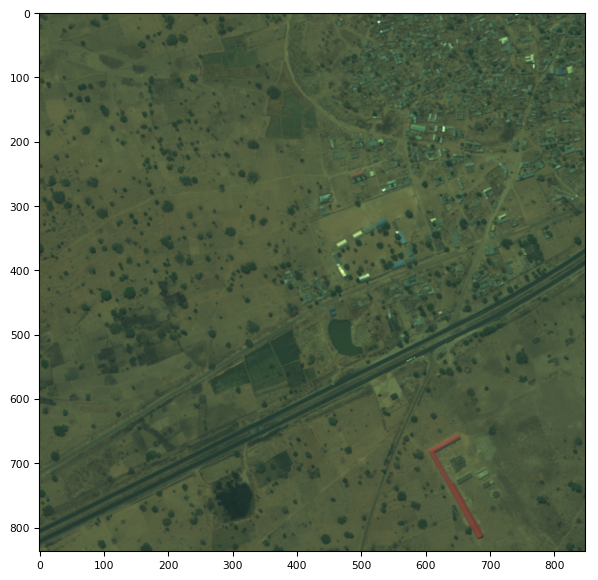

In [14]:
rgb_img = img[(4,2,1),:,:]
tiff.imshow(rgb_img)

Note that we selected only RGB-channels to plot the image.
All 8 channels can be seen interactively using `tiff.imshow()` function. However, this functionality does not work in jupyter notebooks, so, to show an image any 3 channels need to be selected manually.

This could also be done using [matplotlib](https://pypi.python.org/pypi/matplotlib) directly, but in that case the image array should be transposed, so that channels go last. <br>
It is also necessary to normalize image since matplotlib works with 8-bit integers or with doubles in range of [0,1].

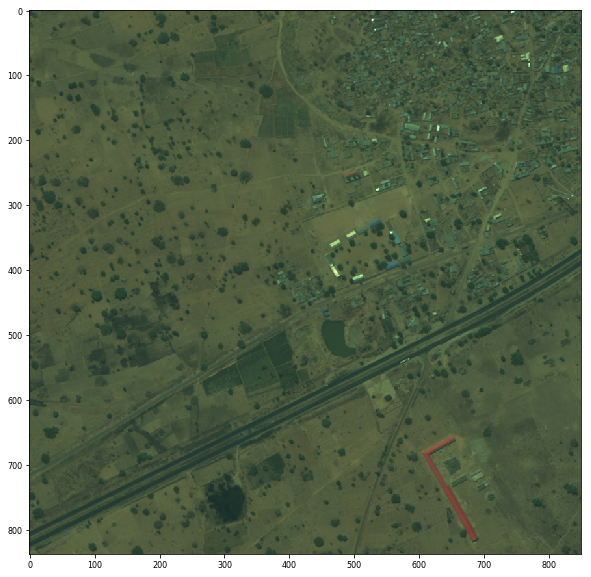

In [17]:
plt.imshow(rgb_img.transpose([1, 2, 0]) / rgb_img.max())

Also available are correctly segmented images of each training location, called **mask**. <br>
These files contain information about 5 different classes: buildings, roads, trees, crops and water (note that original Kaggle contest had 10 classes). 

Open these files like previous ones:

In [18]:
mask = tiff.imread('data/gt_mband/{}.tif'.format(id))
print(type(mask))
print(mask.dtype)
print(mask.shape)

<class 'numpy.ndarray'>
uint8
(5, 837, 849)


Note that resolution of these images coincides with resolution of mband images. However, mask-files are 8-bit.

In [19]:
import numpy as np
np.unique(mask)

array([  0, 255], dtype=uint8)

Image `mask` contains only two values: 0 and 255. Value `mask[c,i,j] == 255` indicates that the pixel with coordinates **[i,j]** is of class **`c`**. If `mask[c,i,j] == 0` then this pixel does not belong to class **`c`**.

Note that one pixel can belong to several or none of the classes (i.e. classes are not disjoint). 

In order to plot the mask we could use `tiff.imshow(mask)`. However, in Jupyter notebooks it can show only mask for class class 0 (i.e. buildings).

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x10849f048>)

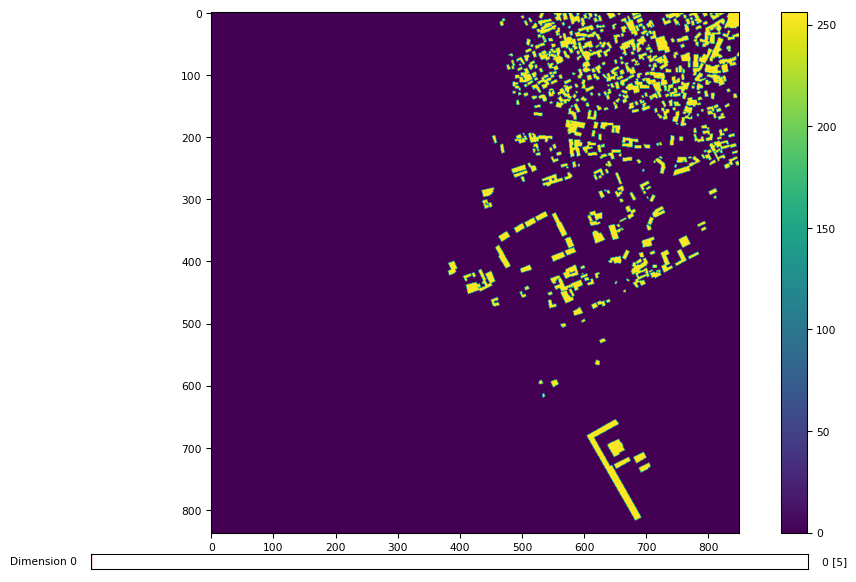

In [20]:
tiff.imshow(mask)

The following function superimposes mask of one class on rgb image:

In [21]:
def superimpose_2d_mask_on_img(img, mask, mask_color=(10, 0, 0)):
    # since imgs are 16-bit and masks are 8-bit images, first normalize rgbs
    normalized_img = img * 255.0 / img.max()
    colored_mask = np.stack([mask_color[0]*mask, mask_color[1]*mask, mask_color[2]*mask])
    im = (normalized_img + colored_mask).clip(0, 255).astype(np.uint8)
    return im

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1215ab438>)

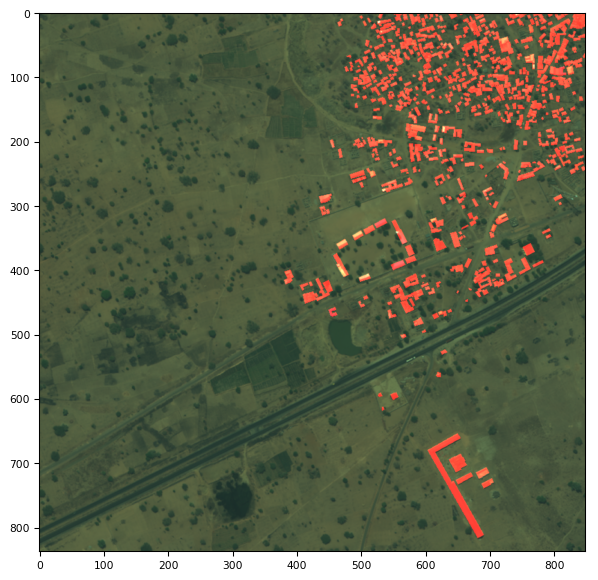

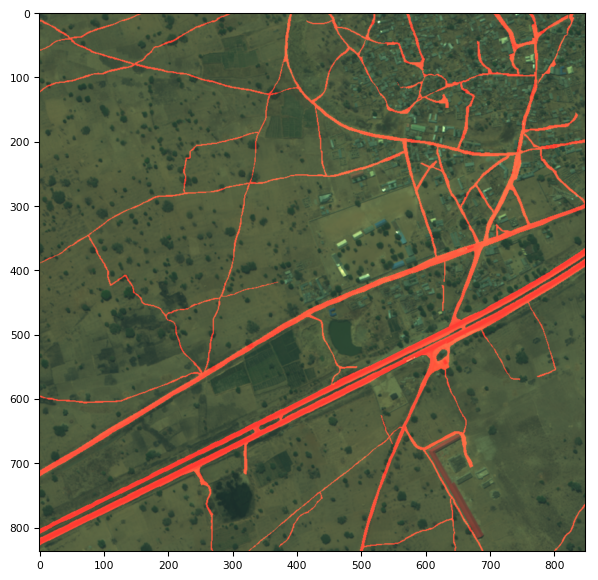

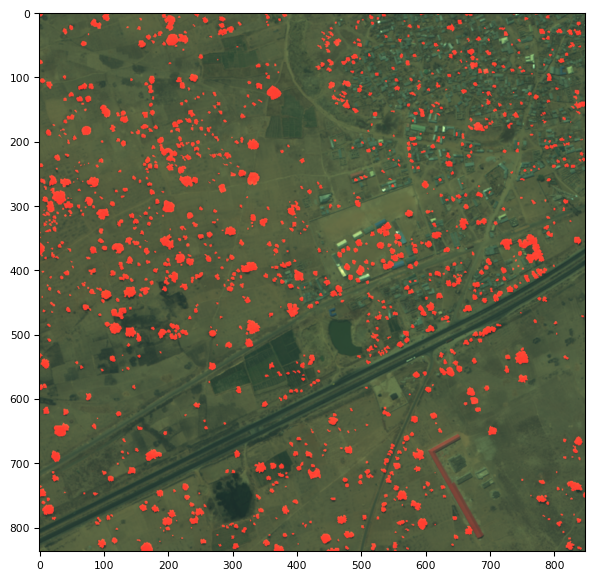

In [22]:
tiff.imshow( superimpose_2d_mask_on_img(rgb_img, mask[0,:,:]) )  # buildings
tiff.imshow( superimpose_2d_mask_on_img(rgb_img, mask[1,:,:]) )  # roads
tiff.imshow( superimpose_2d_mask_on_img(rgb_img, mask[2,:,:]) )  # trees

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1177bc080>)

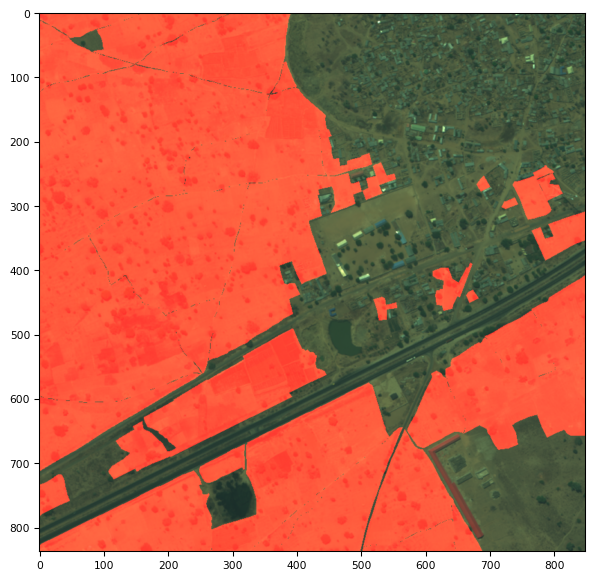

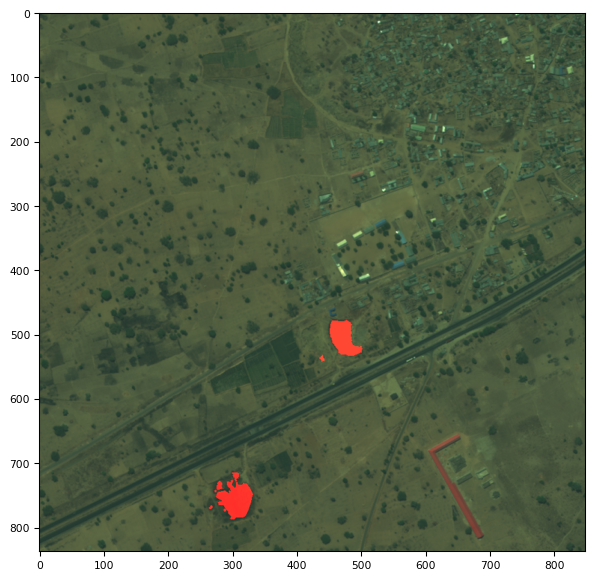

In [23]:
tiff.imshow( superimpose_2d_mask_on_img(rgb_img, mask[3,:,:]) )  # crops
tiff.imshow( superimpose_2d_mask_on_img(rgb_img, mask[4,:,:]) )  # water

Sometimes it is convenient to make masks more readable like geodesic maps. 

The following function does exactly that:

In [24]:
def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150],  # Buildings
        1: [223, 194, 125],  # Roads & Tracks
        2: [27, 120, 55],    # Trees
        3: [166, 219, 160],  # Crops
        4: [116, 173, 209]   # Water
    }
    z_order = {
        1: 3,    # crops
        2: 4,    # water
        3: 0,    # buildings
        4: 1,    # roads
        5: 2     # trees
    }
    pict = 255*np.ones(shape=(3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1, 6):
        cl = z_order[i]
        for ch in range(3):
            pict[ch,:,:][mask[cl,:,:] > threshold] = colors[cl][ch]
    return pict

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x11b94d438>)

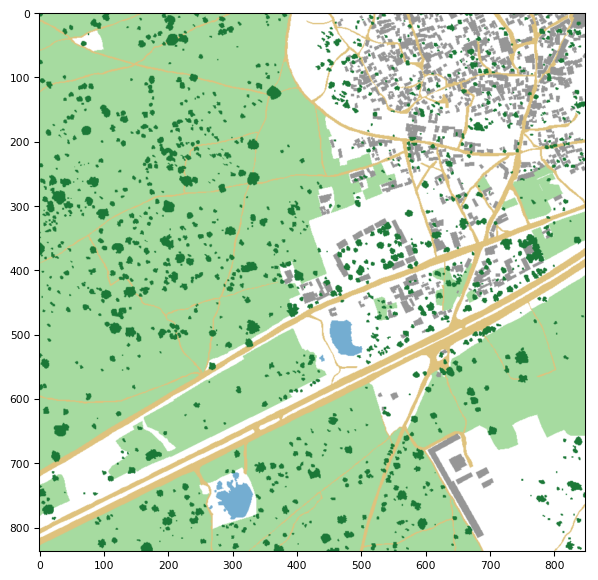

In [25]:
mask_pict = picture_from_mask(mask)
tiff.imshow(mask_pict)

We can concatenate original image and the generated mask picture. <br>
For that both `img` and `mask_pict` need to be *normalized* since former one is 16-bit image and latter is 8-bit.

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x11b968b00>)

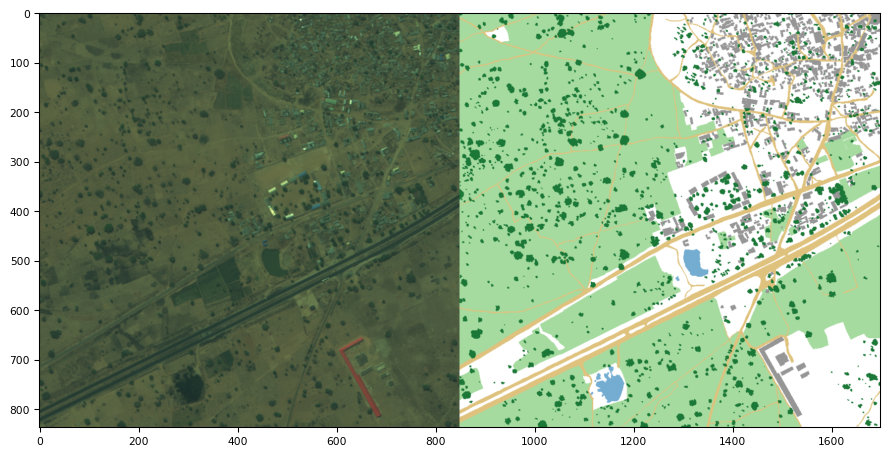

In [26]:
z = np.concatenate([rgb_img / rgb_img.max(), mask_pict / mask_pict.max()], axis=2)
tiff.imshow(z)

**Explore images of different locations from train data set and their masks. After that proceed to predicting classes on test image. The problem is called "image segmentation".**